In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full')
data_dir

PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full')

In [4]:
Artifacts = list(data_dir.glob('Artifacts/*'))
Artifacts[:5]

[PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full/Artifacts/object109-2.tif'),
 PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full/Artifacts/object92-5.tif'),
 PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full/Artifacts/object91-1.tif'),
 PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full/Artifacts/object69-10.tif'),
 PosixPath('/content/drive/MyDrive/Spring 2021/489/Project 1/malaria_full/Artifacts/object31-4.tif')]

In [5]:
stage_images_dict = {
    'Artifacts': list(data_dir.glob('Artifacts/*')),
    'Extracellular Parasites': list(data_dir.glob('Extracellular Parasites/*')),
    'Mature Trophozoites': list(data_dir.glob('Mature Trophozoites/*')),
    'Ring Trophozoites': list(data_dir.glob('Ring Trophozoites/*')),
    'Ruptured Schizont': list(data_dir.glob('Ruptured Schizont/*')),
    'Schizonts': list(data_dir.glob('Schizonts/*')),
    'White Blood Cells': list(data_dir.glob('White Blood Cells/*')),
}
stage_labels_dict = {
    'Artifacts': 0,
    'Extracellular Parasites': 1,
    'Mature Trophozoites': 2,
    'Ring Trophozoites': 3,
    'Ruptured Schizont': 4,
    'Schizonts': 5,
    'White Blood Cells': 6,
}

In [6]:
img = cv2.imread(str(stage_images_dict['Artifacts'][0]))
img.shape

(102, 102, 3)

In [7]:
cv2.resize(img,(128,128)).shape

(128, 128, 3)

In [8]:
X, y = [], []

for stage_name, images in stage_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(stage_labels_dict[stage_name])

In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [12]:
from skimage.color import rgb2gray

grayscale_train = rgb2gray(X_train_scaled)

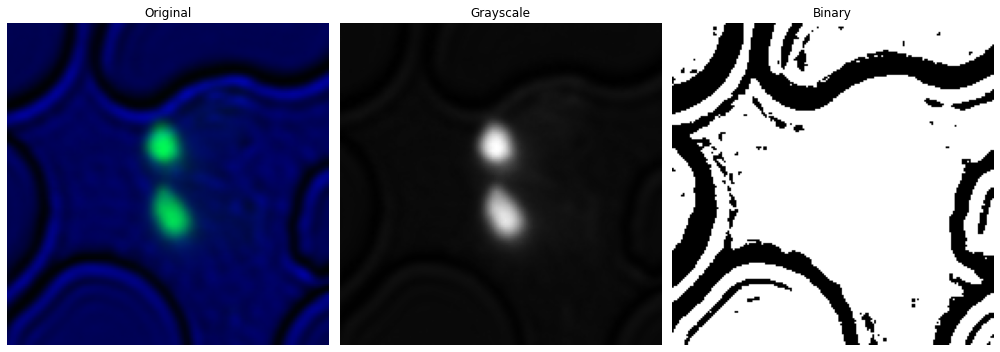

In [13]:
gray_threshold = 0.02727 #0.02727
binary_image_train = grayscale_train > gray_threshold

fig, axes = plt.subplots(1, 3, figsize=(14, 8))
ax = axes.ravel()

i = 4

ax[0].imshow(X_train_scaled[i])
ax[0].axis("off")
ax[0].set_title("Original")
ax[1].imshow(grayscale_train[i], cmap=plt.cm.gray)
ax[1].axis("off")
ax[1].set_title("Grayscale")
ax[2].imshow(binary_image_train[i], cmap=plt.cm.gray)
ax[2].axis("off")
ax[2].set_title("Binary")

fig.tight_layout()
plt.show()

In [14]:
print(X_train_scaled.shape)
print(binary_image_train.shape)

(707, 180, 180, 3)
(707, 180, 180)


In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [16]:
num_classes = 7
model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [17]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weights)
class_weights = {0: 0.62732919  ,
                1: 0.50753769,
                2: 2.72972973,
                3: 0.3556338,
                4: 14.42857143,
                5: 16.83333333,
                6: 7.76923077}

[ 0.62732919  0.50753769  2.72972973  0.3556338  14.42857143 16.83333333
  7.76923077]


In [19]:
grayscale_test = rgb2gray(X_test_scaled)
binary_image_test = grayscale_test > gray_threshold 
binary_image_test = binary_image_test.reshape(236, 180, 180, 1)

x_val = X_test_scaled
y_val = y_test

In [20]:
binary_image_train = binary_image_train.reshape(707, 180, 180, 1)         
hist = model.fit(X_train_scaled, y_train, epochs=20, class_weight=class_weights,validation_data=(x_val, y_val))

Epoch 1/20
23/23 [==============================] - 27s 1s/step - loss: 1.9382 - accuracy: 0.2016 - val_loss: 1.3595 - val_accuracy: 0.4449
Epoch 2/20
23/23 [==============================] - 25s 1s/step - loss: 1.7807 - accuracy: 0.2890 - val_loss: 1.2519 - val_accuracy: 0.4153
Epoch 3/20
23/23 [==============================] - 25s 1s/step - loss: 1.0354 - accuracy: 0.3477 - val_loss: 1.2140 - val_accuracy: 0.5085
Epoch 4/20
23/23 [==============================] - 25s 1s/step - loss: 1.0428 - accuracy: 0.3812 - val_loss: 1.0508 - val_accuracy: 0.4746
Epoch 5/20
23/23 [==============================] - 25s 1s/step - loss: 1.3027 - accuracy: 0.4196 - val_loss: 1.1387 - val_accuracy: 0.5847
Epoch 6/20
23/23 [==============================] - 25s 1s/step - loss: 0.8597 - accuracy: 0.5072 - val_loss: 1.1880 - val_accuracy: 0.4110
Epoch 7/20
23/23 [==============================] - 25s 1s/step - loss: 0.7501 - accuracy: 0.4328 - val_loss: 1.1242 - val_accuracy: 0.5042
Epoch 8/20
23/23 [==

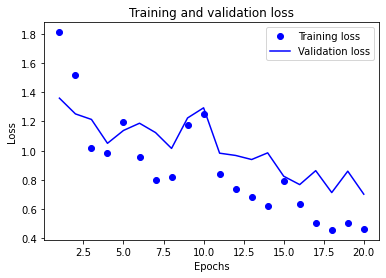

In [21]:
# plot the loss
history_dict = hist.history
loss_values = history_dict['loss']
acc = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training loss") # blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

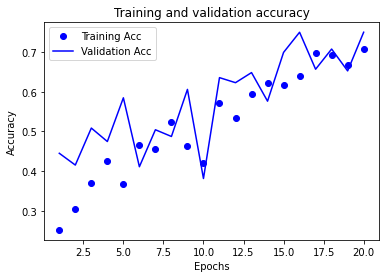

In [22]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.summary()

In [23]:
grayscale_test = rgb2gray(X_test_scaled)
binary_image_test = grayscale_test > gray_threshold 
binary_image_test = binary_image_test.reshape(236, 180, 180, 1)
model.evaluate(X_test_scaled,y_test)

8/8 [==============================] - 2s 248ms/step - loss: 0.7030 - accuracy: 0.7500


[0.7029543519020081, 0.75]

In [24]:
from sklearn.metrics import confusion_matrix , classification_report
test_results = model.predict(X_test_scaled)
results = np.argmax(test_results, axis = 1)
print(results)
test_label = y_test
    
print("Classification Report: \n", classification_report(test_label, results))

[3 3 3 3 2 1 2 1 3 3 1 1 3 3 1 3 1 2 3 3 3 1 3 5 1 3 2 1 2 3 0 3 2 1 6 3 3
 3 0 3 3 1 1 1 3 0 3 3 3 1 1 1 3 3 1 3 1 3 3 3 1 4 3 3 1 3 3 3 1 0 3 1 1 3
 3 3 3 1 3 2 1 3 1 3 0 3 1 3 3 3 4 3 3 1 6 6 2 1 3 1 0 3 3 3 3 3 3 3 1 0 0
 3 1 2 1 3 0 3 1 1 3 1 3 3 1 3 3 2 2 3 1 1 6 3 3 3 1 3 3 6 3 5 3 1 6 5 1 3
 6 3 3 2 0 3 2 1 1 3 3 1 3 3 0 6 0 4 3 3 0 0 1 1 3 6 1 3 3 3 3 2 1 0 6 1 3
 3 0 6 3 1 6 3 1 3 3 1 1 3 0 1 0 3 3 3 1 3 1 3 3 3 1 3 3 3 3 0 3 3 1 3 3 2
 1 1 1 0 3 3 3 3 3 2 1 3 3 0]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.45      0.58        38
           1       0.84      0.70      0.76        76
           2       0.44      0.70      0.54        10
           3       0.72      0.90      0.80        94
           4       0.33      1.00      0.50         1
           5       0.67      0.40      0.50         5
           6       1.00      1.00      1.00        12

    accuracy                           0.75       236
   macr

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_label, results)

array([[17,  6,  1, 14,  0,  0,  0],
       [ 3, 53,  3, 16,  0,  1,  0],
       [ 0,  0,  7,  3,  0,  0,  0],
       [ 1,  4,  4, 85,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  2,  2,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])